In [62]:
import os
import sys
from pprint import pprint
from dotenv import load_dotenv
import pandas as pd
import numpy as np
#import seaborn as sns
#import time
import xgboost as xgb
from xgboost import plot_tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import operator
import random
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


#conda install -c conda-forge bayesian-optimization
from bayes_opt import BayesianOptimization
import pandas_profiling
load_dotenv('forecast_arosa.env')
random.seed(22)

# Open CSV


In [37]:
path_in = os.getenv('DATAIN') # this is where we downloaded the tabel

In [38]:
file_name = os.getenv('DATASET_FILENAME') # this is where we downloaded the tabel

In [39]:
os.path.join(path_in, file_name)

'../arosa_data/arosa_data_feature1.csv'

In [40]:
df = pd.read_csv(os.path.join(path_in, file_name),delimiter=';')
df

,Datum,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
0,01.01.2016,Freitag,winter season,1,53,1,1,1,0,NaN,...,0.81,1.3,2.6,1.1,0,0,10,20,5,35
1,02.01.2016,Samstag,winter season,2,53,1,1,1,0,NaN,...,1.21,1.9,5.4,0.0,0,0,78,59,22,159
2,03.01.2016,Sonntag,winter season,3,53,1,1,1,0,NaN,...,0.23,0.0,5.9,0.0,0,0,0,0,0,0
3,04.01.2016,Montag,winter season,4,1,0,0,0,0,NaN,...,0.13,0.3,2.4,0.0,0,0,0,0,0,0
4,05.01.2016,Dienstag,winter season,5,1,0,0,0,0,NaN,...,0.00,0.0,3.4,1.3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,27.08.2019,Dienstag,summer season,1335,35,0,0,0,0,NaN,...,0.00,0.0,11.2,0.0,2,0,59,26,29,114
1335,28.08.2019,Mittwoch,summer season,1336,35,0,0,0,0,NaN,...,0.00,0.0,5.6,1.1,2,0,61,40,19,120
1336,29.08.2019,Donnerstag,summer season,1337,35,0,0,0,0,NaN,...,0.16,0.0,5.8,0.0,2,0,76,38,23,137
1337,30.08.2019,Freitag,summer season,1338,35,0,0,0,0,NaN,...,0.00,0.0,5.7,0.7,3,0,157,48,27,232


In [41]:
df[df['Datum']=='31.08.2019']

,Datum,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
1338,31.08.2019,Samstag,summer season,1339,35,1,1,1,0,NaN,...,0.03,0.0,5.8,2.9,3,0,183,33,23,239


In [42]:
len(df)

1339

# Preprocessing

In [ ]:
df

In [53]:
df= df[df.Datum != '09.03.2016']
d=df.drop(['Datum'], axis=1)
d['Ferien Desc ZH'].fillna(value=0, inplace = True)
d['Ferien Desc GR'].fillna(value=0, inplace = True)
d['Ferien Desc SG'].fillna(value=0, inplace = True)
d['Feiertag Desc'].fillna(value=0, inplace = True)
d['Feiertag Desc']

0             Neujahr
1       Berchtoldstag
2                   0
3                   0
4                   0
            ...      
1334                0
1335                0
1336                0
1337                0
1338                0
Name: Feiertag Desc, Length: 1338, dtype: object

In [56]:
d = d.astype({"Ferien Desc ZH": str, "Ferien Desc GR": str, "Ferien Desc SG": str, "Feiertag Desc": str})

In [57]:
# Create a boolean mask for categorical columns 
categorical_mask = (d.dtypes == object)  # true → is categorical
# Get list of categorical column names
categorical_columns = d.columns[categorical_mask].tolist()
# Print the head of the categorical columns 
print(d[categorical_columns].head())
# Create LabelEncoder object: le 
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
d[categorical_columns] = d[categorical_columns].apply(lambda x: le.fit_transform(x))
# Print the head of the LabelEncoded categorical columns print(df[categorical_columns].head())

  Wochentag         season Ferien Desc ZH Ferien Desc SG Ferien Desc GR  \
0   Freitag  winter season              0              0              0   
1   Samstag  winter season              0              0              0   
2   Sonntag  winter season              0              0              0   
3    Montag  winter season              0              0              0   
4  Dienstag  winter season              0              0              0   

   Feiertag Desc  
0        Neujahr  
1  Berchtoldstag  
2              0  
3              0  
4              0  


# Overview of Data

In [58]:
#df.profile_report()

# Random Forest

In [86]:
X2, y2 = d.iloc[:,:-4],d.iloc[:,-4]
X_train_2, X_test_2, y_train_2, y_test_2= train_test_split(X2, y2, test_size=0.2, 
                                                        random_state=122, shuffle=False)
len(X_test_2)
df[-268:]

,Datum,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
1071,07.12.2018,Freitag,winter season,1072,49,0,0,0,0,nan,...,0.00,0.0,11.5,0.0,1,1,43,41,31,115
1072,08.12.2018,Samstag,winter season,1073,49,1,1,1,0,nan,...,3.14,5.3,12.2,0.0,1,1,40,35,20,95
1073,09.12.2018,Sonntag,winter season,1074,49,1,1,1,0,nan,...,5.78,9.2,14.0,0.0,1,1,35,30,15,80
1074,10.12.2018,Montag,winter season,1075,50,0,0,0,0,nan,...,4.90,7.7,12.1,0.0,1,1,33,36,32,101
1075,11.12.2018,Dienstag,winter season,1076,50,0,0,0,0,nan,...,0.28,0.0,11.8,0.0,3,1,37,40,35,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,27.08.2019,Dienstag,summer season,1335,35,0,0,0,0,nan,...,0.00,0.0,11.2,0.0,2,0,59,26,29,114
1335,28.08.2019,Mittwoch,summer season,1336,35,0,0,0,0,nan,...,0.00,0.0,5.6,1.1,2,0,61,40,19,120
1336,29.08.2019,Donnerstag,summer season,1337,35,0,0,0,0,nan,...,0.16,0.0,5.8,0.0,2,0,76,38,23,137
1337,30.08.2019,Freitag,summer season,1338,35,0,0,0,0,nan,...,0.00,0.0,5.7,0.7,3,0,157,48,27,232


In [89]:
df[df['Datum']=='07.12.2017']

,Datum,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
706,07.12.2017,Donnerstag,winter season,707,49,0,0,0,0,nan,...,0.0,0.0,8.9,1.6,0,1,35,38,26,99


In [91]:
df[df['Datum']=='31.08.2018']

,Datum,Wochentag,season,TagNr,WocheNr,isFreiZH,isFreiSG,isFreiGR,isFerienZH,Ferien Desc ZH,...,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,isHumorfestival,Schalter,Tel,Mail,Total Anfragen
973,31.08.2018,Freitag,summer season,974,35,0,0,0,0,nan,...,2.11,0.0,4.9,0.0,0,0,28,28,12,68


In [93]:
df.iloc[705:973,-4]

706    35
707    48
708    32
709    27
710    32
       ..
969    42
970    39
971    29
972    41
973    28
Name: Schalter, Length: 268, dtype: int64

In [74]:
regressor = RandomForestRegressor(n_estimators=40, random_state=1)
regressor.fit(X_train_2, y_train_2)
y_pred_2 = regressor.predict(X_test_2)

In [76]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

Mean Absolute Error: 21.18348880597015
Mean Squared Error: 1270.60953125
Root Mean Squared Error: 35.64561026620248
Mean Absolute Percentage Error : 0.4686706045268409


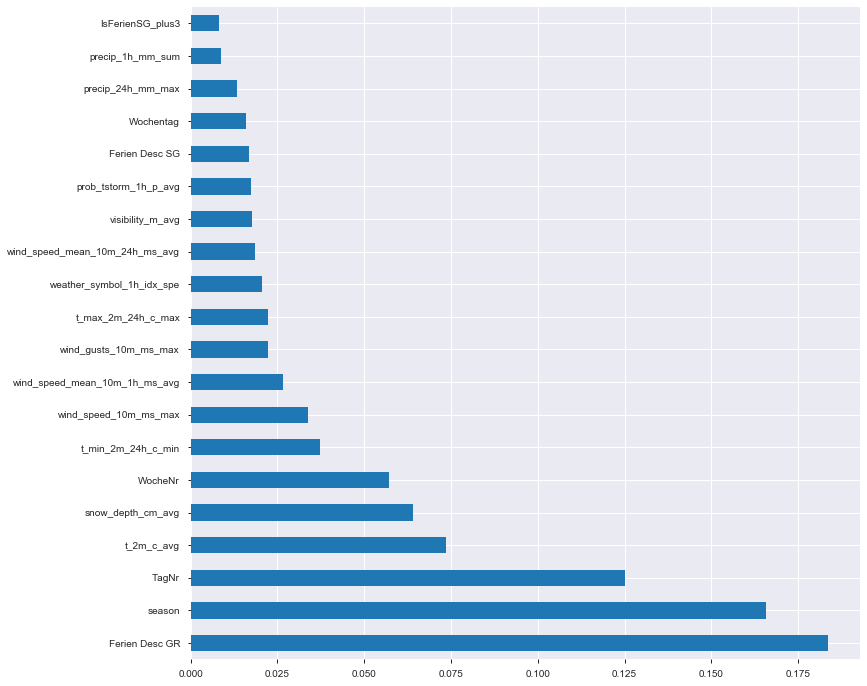

In [81]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_2, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_2, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_2, y_pred)))
print("Mean Absolute Percentage Error : " + str(mape_vectorized_v2( y_test_2, y_pred)))

feat_importances = pd.Series(regressor.feature_importances_, index=X2.columns)
width = 12
height = 12
plt.figure(figsize=(width, height))
feat_importances.nlargest(20).plot(kind='barh')

Text(0.5, 1.0, 'Schalter Besucher:Prediction vs. Test Value')

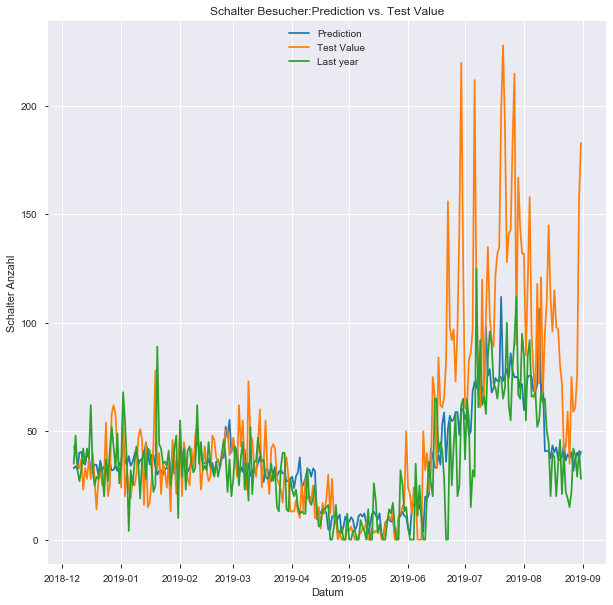

In [94]:
width = 10
height = 10
plt.figure(figsize=(width, height))
t = pd.date_range(start='2018-12-07',end='2019-08-31')

plt.plot
plt.plot(t, y_pred)
plt.plot(t, y_test_2)
plt.plot(t, df.iloc[705:973,-4])

plt.xlabel('Datum')
plt.ylabel('Schalter Anzahl')
plt.legend(('Prediction', 'Test Value','Last year'), loc='upper center')
plt.title('Schalter Besucher:Prediction vs. Test Value')

# Preprocessing Error

In [78]:
list = ['Datum',
 'Wochentag',
 'season',
 'isFerienZH',
 'Ferien Desc ZH',
 'isFerienSG',
 'Ferien Desc SG',
 'isFerienGR',
 'Ferien Desc GR',
 'Feiertag Desc',
 'isFeiertag ZH',
 'isFeiertag SG',
 'isFeiertag GR',
 't_2m_c_avg',
 'snow_depth_cm_avg',
 'visibility_m_avg',
 'wind_speed_10m_ms_max',
 'prob_precip_1h_p_avg',
 'prob_tstorm_1h_p_avg',
 'hail_idx_avg',
 'wind_gusts_10m_ms_max',
 'wind_speed_mean_10m_24h_ms_avg',
 't_max_2m_24h_c_max',
 't_min_2m_24h_c_min',
 'precip_24h_mm_max',
 'fresh_snow_24h_cm_max',
 'is_sleet_1h_idx_max',
 'is_fog_1h_idx_max',
 'precip_1h_mm_sum',
 'fresh_snow_1h_cm_sum',
 'wind_speed_mean_10m_1h_ms_avg',
 'weather_symbol_1h_idx_spe',
 'number_of_events',
 'Schalter',
 'Tel',
 'Mail',
 'Total Anfragen']
df = df[list]

## LabelEncoder 

In [79]:
df['Ferien Desc ZH'].fillna(value=0, inplace = True)
df['Ferien Desc GR'].fillna(value=0, inplace = True)
df['Ferien Desc SG'].fillna(value=0, inplace = True)
df['Feiertag Desc'].fillna(value=0, inplace = True)

In [80]:
df = df.astype({"Ferien Desc ZH": str, "Ferien Desc GR": str, "Ferien Desc SG": str, "Feiertag Desc": str})

In [81]:
df['Ferien Desc ZH'].value_counts()

0                   1023
Sommerferien         145
Sportferien           64
Fruehlingsferien      61
Herbstferien          45
Name: Ferien Desc ZH, dtype: int64

In [82]:
df=df.drop(['Datum'],axis=1)
df

,Wochentag,season,isFerienZH,Ferien Desc ZH,isFerienSG,Ferien Desc SG,isFerienGR,Ferien Desc GR,Feiertag Desc,isFeiertag ZH,...,is_fog_1h_idx_max,precip_1h_mm_sum,fresh_snow_1h_cm_sum,wind_speed_mean_10m_1h_ms_avg,weather_symbol_1h_idx_spe,number_of_events,Schalter,Tel,Mail,Total Anfragen
0,Freitag,winter season,0,0,0,0,0,0,Neujahr,1,...,1,0.81,1.3,2.6,1.1,0,10,20,5,35
1,Samstag,winter season,0,0,0,0,0,0,Berchtoldstag,0,...,1,1.21,1.9,5.4,0.0,0,78,59,22,159
2,Sonntag,winter season,0,0,0,0,0,0,0,0,...,0,0.23,0.0,5.9,0.0,0,0,0,0,0
3,Montag,winter season,0,0,0,0,0,0,0,0,...,0,0.13,0.3,2.4,0.0,0,0,0,0,0
4,Dienstag,winter season,0,0,0,0,0,0,0,0,...,0,0.00,0.0,3.4,1.3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,Dienstag,summer season,0,0,0,0,0,0,0,0,...,0,0.00,0.0,11.2,0.0,2,59,26,29,114
1335,Mittwoch,summer season,0,0,0,0,0,0,0,0,...,0,0.00,0.0,5.6,1.1,2,61,40,19,120
1336,Donnerstag,summer season,0,0,0,0,0,0,0,0,...,0,0.16,0.0,5.8,0.0,2,76,38,23,137
1337,Freitag,summer season,0,0,0,0,0,0,0,0,...,0,0.00,0.0,5.7,0.7,3,157,48,27,232


In [83]:
# Create a boolean mask for categorical columns 
categorical_mask = (df.dtypes == object)  # true → is categorical
# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()
# Print the head of the categorical columns 
print(df[categorical_columns].head())
# Create LabelEncoder object: le 
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))
# Print the head of the LabelEncoded categorical columns print(df[categorical_columns].head())

  Wochentag         season Ferien Desc ZH Ferien Desc SG Ferien Desc GR  \
0   Freitag  winter season              0              0              0   
1   Samstag  winter season              0              0              0   
2   Sonntag  winter season              0              0              0   
3    Montag  winter season              0              0              0   
4  Dienstag  winter season              0              0              0   

   Feiertag Desc  
0        Neujahr  
1  Berchtoldstag  
2              0  
3              0  
4              0  


## One Hot Encoding

In [84]:
# Create OneHotEncoder: ohe
ohe = OneHotEncoder(categorical_features=categorical_mask, sparse=False)
# Apply OneHotEncoder to categorical columns - output is no longer a dataframe: df_encoded df_encoded = ohe.fit_transform(df)
# Print first 5 rows of the resulting dataset - again, this will no longer be a pandas dataframe print(df_encoded[:5, :])
# Print the shape of the original DataFrame 
d_encoded = ohe.fit_transform(df)
print(df.shape)
# Print the shape of the transformed array 
print(d_encoded.shape)
print(type(d_encoded))
d_encoded

(1338, 36)
(1338, 96)
<class 'numpy.ndarray'>


/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


array([[  0.,   0.,   1., ...,  20.,   5.,  35.],
       [  0.,   0.,   0., ...,  59.,  22., 159.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   0., ...,  38.,  23., 137.],
       [  0.,   0.,   1., ...,  48.,  27., 232.],
       [  0.,   0.,   0., ...,  33.,  23., 239.]])

## Modelling

In [85]:
print(d_encoded[:,:-4].shape)

(1338, 92)


In [86]:
X, y = d_encoded[:,:-4],d_encoded[:,-4]
print(X.shape)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, 
                                                        random_state=122, shuffle=False)
DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

(1338, 92)


In [87]:
params = {"booster":"gblinear","objective":"reg:linear"}
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)

preds = xg_reg.predict(DM_test)

rmse = np.sqrt(mean_squared_error(y_test,preds))

print("RMSE: %f" % (rmse))

[10:45:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 32.232475


In [88]:
def train_model(max_depth, 
                n_estimators,
                learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'learning_rate':learning_rate,
        'n_jobs': 8, #number of CPU threads
        "booster":"gblinear",
        "objective":"reg:squarederror"
    }

#     pipeline = Pipeline([
#                      ("vectorizer", DictVectorizer(sort=False)),
#                      ("clf", xgb.XGBRegressor(objective = 'reg:squarederror',**params)),

#                         ])
    
#     xgb_fit = pipeline.fit(DM_train)
#     preds = xgb_fit.predict(DM_test)
#     mse = mean_absolute_error(preds, y_test)

    xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)
    preds = xg_reg.predict(DM_test)
    mse = np.sqrt(mean_squared_error(preds, y_test))
    return -mse

bounds = {
    'max_depth':(5,100),
    'n_estimators': (100,10000),
    'learning_rate': (.001, 0.1),
}

In [89]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
    verbose=2,
)
best = optimizer.maximize(init_points=10, n_iter= 10)
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -35.53    |  0.04229  |  73.43    |  101.1    |
|  2        | -36.69    |  0.03093  |  18.94    |  1.014e+0 |
|  3        | -39.2     |  0.01944  |  37.83    |  4.028e+0 |
|  4        | -34.83    |  0.05434  |  44.82    |  6.884e+0 |
|  5        | -38.64    |  0.02124  |  88.42    |  371.1    |
|  6        | -34.39    |  0.06738  |  44.64    |  5.631e+0 |
|  7        | -41.12    |  0.0149   |  23.82    |  8.027e+0 |
|  8        | -33.88    |  0.09686  |  34.78    |  6.954e+0 |
|  9        | -33.99    |  0.08776  |  89.99    |  941.9    |
|  10       | -52.12    |  0.004866 |  21.13    |  8.794e+0 |
|  11       | -36.94    |  0.02929  |  78.65    |  6.949e+0 |
|  12       | -33.84    |  0.1      |  21.98    |  6.928e+0 |
|  13       | -33.84    |  0.1      |  8.677    |  6.955e+0 |
|  14       | -34.47    |  0.06447  |  64.99    |  930.1    |
|  15   